In [32]:
package SyringeSystem {
    import ISQ::*;
    package Library{
        import Ports::*;
        import ExternalSystems::*;
        import PartDefs::*;
        import Actors::*;
        package 'Ports' {
            port def Hand {
                inout force;
            }
            port def ExtLuer{
                inout item fluid:Fluid;
            }
            item def Fluid;
            interface def LuerInterface{
                flow of Fluid
                    from ExtPort.fluid to IntPort.fluid;
                flow of Fluid
                    from IntPort.fluid to ExtPort.fluid;
                end ExtPort : ExtLuer;
                end IntPort: ~ExtLuer;
            }
        }
        package 'ExternalSystems'{
            item def Vial{
                port septum{
                    inout fluid:Fluid;
                }
                item drug:Fluid;
            }
            item def SharpsBin;
            item def Storage;
            item def Needle{
                port Luer: ~ExtLuer;
                port Cannula{
                    inout fluid:Fluid;
                }
            }
        }
        package PartDefs{
            part def Syringe{
                port Handle;
                port NeedleAttachment : ExtLuer;
                timeslice storage;
                timeslice inUse{
                    interface : LuerInterface connect
                        ExtPort ::> NeedleAttachment to 
                        IntPort ::> needle.Luer;
                    ref item vial:Vial;
                    ref item needle:Needle;
                    ref item hcp:HCP{
                        perform action UnpackageSyringe{}
                        perform action AssembleNeedle{}
                        perform action FillDrug{}
                        perform action DeliverDrug{}
                    }
                    ref item patient:Patient;
                    timeslice filling{
                        connect needle.Cannula to vial.septum;
                        
                    }
                    timeslice delivery{
                        connect needle.Cannula to patient.injectionSite;
                    }
                }
                timeslice disposed = done{
                    ref item sharpsBin : SharpsBin;
                }
            }
        }
        package ActionDefs{
            action def TreatPatient {
                in syringe : Syringe;
                in needle : Needle;
                in patient : Patient;
                in vial : Vial;
                bind UnpackageSyringe.syringePackaged = syringe;
                bind AssembleNeedle.needle = needle;
                bind FillDrug.vial = vial;
                action UnpackageSyringe {in syringePackaged; out syringeUnpackaged;}
                action AssembleNeedle {in syringeNoNeedle; in needle; out syringeWithNeedle;}
                flow UnpackageSyringe.syringeUnpackaged to AssembleNeedle.syringeNoNeedle;
                action FillDrug{in syringeUnfilled; in vial; out syringeFilled;}
                flow AssembleNeedle.syringeWithNeedle to FillDrug.syringeUnfilled;
                action DeliverDrug{in syringeUndelivered; out syringeDelivered;}
                flow FillDrug.syringeFilled to DeliverDrug.syringeUndelivered;
            }            
        }
        package OccurenceDefs{
            occurrence def TreatPatientO {
                
            }
        }
        package 'Actors'{
            part def Human;
            part def HCP :> Human;
            part def Patient :> Human{
                port injectionSite{
                    in drug:Fluid;
                }
            }
        }
    }
    package 'Structure'{
        import Library::*;
        part syringe: Syringe{
            part plunger{
                port 'Seal Mount';
                port 'Thumb Pad';
            }
            part barrel{
                port 'Finger Pad';
                port 'Internal Bore';
                port 'Needle Attachment': ExtLuer;
            }
            part 'plunger seal'{
                port 'Plunger Surface';
                port 'Sealing Surface';
            }
            bind barrel.'Needle Attachment' = NeedleAttachment;
            bind barrel.'Finger Pad' = Handle;
            bind plunger.'Thumb Pad' = Handle;
            connect plunger.'Seal Mount' to 'plunger seal'.'Plunger Surface';
            connect barrel.'Internal Bore' to 'plunger seal'.'Sealing Surface';
        }
    }
}

Package SyringeSystem (a5fd3bcd-8868-4b6a-a9d8-edbe466dad79)


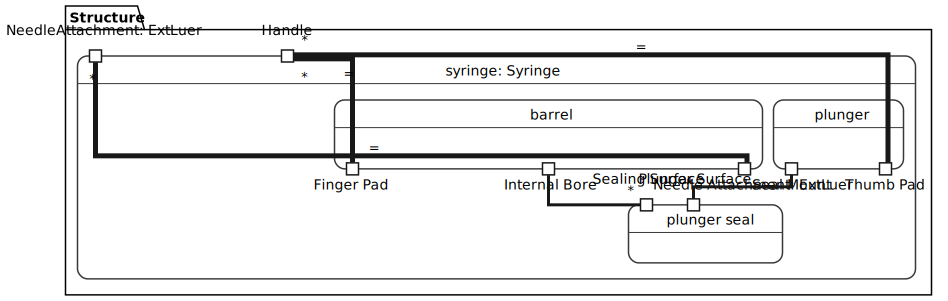

In [18]:
%viz --view=interconnection SyringeSystem::Structure --style=ortholine

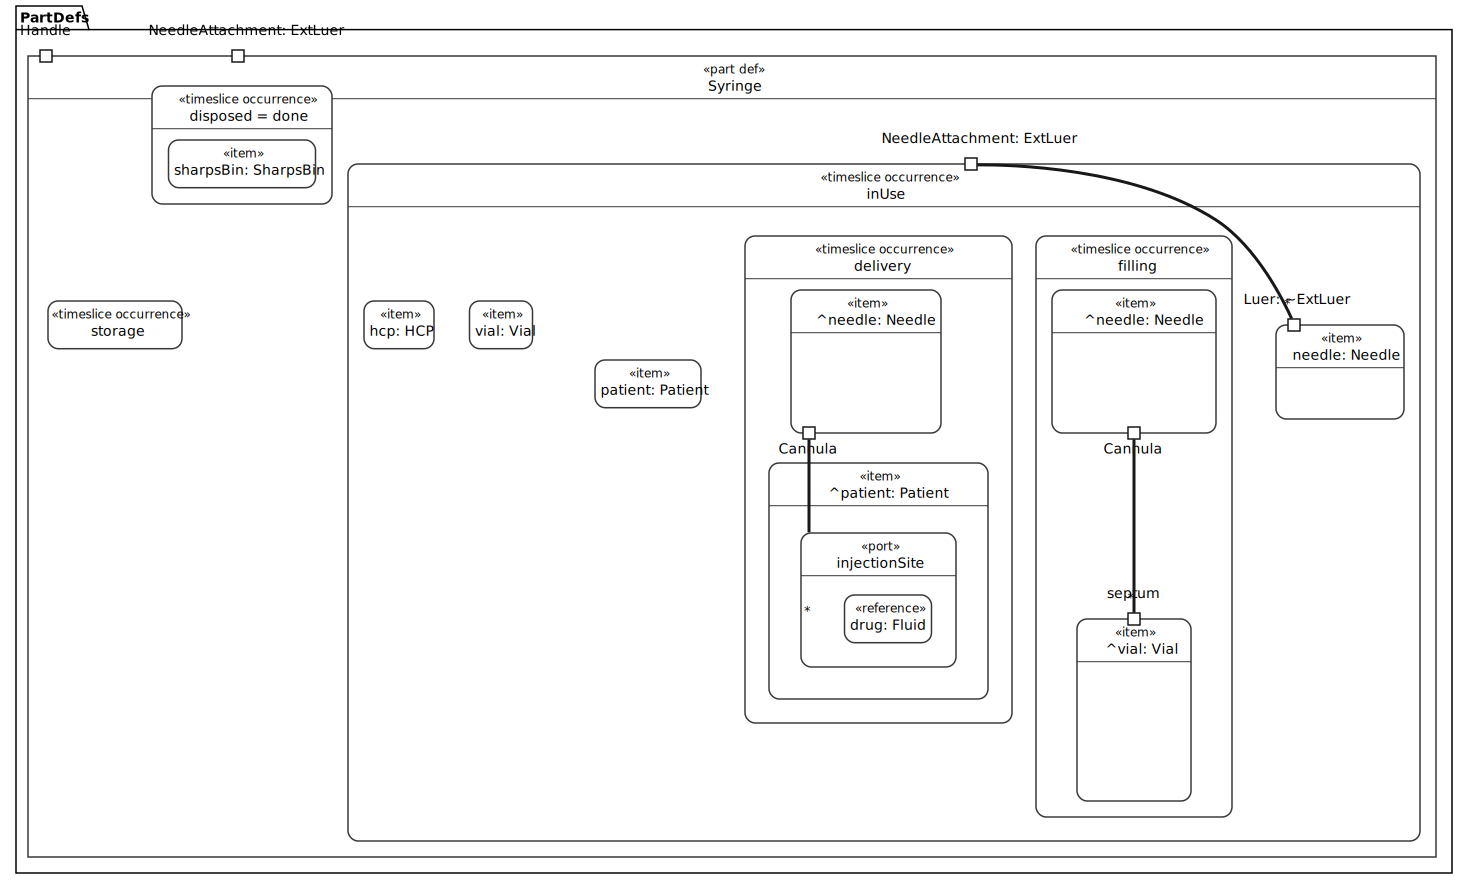

In [38]:
%viz --view=interconnection SyringeSystem::Library::PartDefs 

In [40]:
%viz -h

Usage: %viz [--view=<VIEW>] [--style=<STYLE>...] <NAME> [<NAME>...]

Visualize model elements of <NAME>(s). <NAME>s must be fully qualified.

<VIEW> is case insensitive and possible candidates are:
   DEFAULT		Automatically choose an appropriate view from the given model element names
   TREE			Show a tree-structural view, like a Block Definition Diagram (BDD)
   INTERCONNECTION	Show an interconnection view, like an Internal Block Diagram (IBD)
   STATE		Show state machines
   ACTION		Show actions like an activity diagram
   SEQUENCE		Show events and messages in a sequence diagram
   MIXED		Show multiple views

<STYLE> is also case insensitive. Multiple --style options are allowed.  The possible style names are:
  DEFAULT		Standard B&&W
  STDCOLOR		Standard style with colors
  PLANTUML		PlantUML Style
  TB			Top-to-Bottom orientation
  LR			Left-to-Right orientation
  POLYLINE		Polyline style
  ORTHOLINE		Orthogonal line style
  SHOWLIB		Show elements of the standard libraries
  SHOWIN

In [20]:
package 'Event Occurrence Example' {	
	part def Driver;
	part def CruiseController;
	part def Speedometer;
	part def Engine;
	part def Vehicle;
	
	part driver : Driver {
		event occurrence setSpeedSent;
	}
	
	part vehicle : Vehicle {
	
		part cruiseController : CruiseController {
			event occurrence setSpeedReceived;
			then event occurrence sensedSpeedReceived;		
			then event occurrence fuelCommandSent;
		}
		
		part speedometer : Speedometer {
			event occurrence sensedSpeedSent;
		}
		
		part engine : Engine {
			event occurrence fuelCommandReceived;
		}
	
	}
}

Package Event Occurrence Example (b52c09ff-1c9b-4abe-9cba-67ef921ac8fa)


In [21]:
package 'Interaction Example-1' {
	import 'Event Occurrence Example'::*;
	
	item def SetSpeed;
	item def SensedSpeed;
	item def FuelCommand;
	
	occurrence def CruiseControlInteraction {		
		ref part :>> driver;		
		ref part :>> vehicle;
		
		message setSpeedMessage of SetSpeed 
			from driver.setSpeedSent to vehicle.cruiseController.setSpeedReceived;
			
		message sensedSpeedMessage of SensedSpeed 
			from vehicle.speedometer.sensedSpeedSent to vehicle.cruiseController.sensedSpeedReceived;
			
		message fuelCommandMessage of FuelCommand 
			from vehicle.cruiseController.fuelCommandSent to vehicle.engine.fuelCommandReceived;
		
		first setSpeedMessage then sensedSpeedMessage;
	}
}

Package Interaction Example-1 (5959b608-e78d-4eb1-9f51-2b0089c43c72)


In [22]:
package 'Interaction Realization-1' {
	import 'Interaction Example-1'::*;
	
	part driver_a : Driver {
		action driverBehavior {
			action sendSetSpeed send SetSpeed() to vehicle_a;
		}
	}
	
	part vehicle_a : Vehicle {
		part cruiseController_a : CruiseController {
			action controllerBehavior {
				action receiveSetSpeed accept SetSpeed via vehicle_a;
				then action receiveSensedSpeed accept SensedSpeed via cruiseController_a;
				then action sendFuelCommand send FuelCommand() to engine_a;
			}
		}
		
		part speedometer_a : Speedometer {
			action speedometerBehavior {
				action sendSensedSpeed send SensedSpeed() to cruiseController_a;
			}
		}
		
		part engine_a : Engine {
			action engineBehavior {
				action receiveFuelCommand accept FuelCommand via engine_a;
			}
		}
	}
	
	occurrence cruiseControlInteraction_a : CruiseControlInteraction {
		part :>> driver :>> driver_a {
			event driverBehavior.sendSetSpeed[1] :>> setSpeedSent;
		}
		
		part :>> vehicle :>> vehicle_a {
			part :>> cruiseController :>> cruiseController_a {
				event controllerBehavior.receiveSetSpeed[1] :>> setSpeedReceived;
				event controllerBehavior.receiveSensedSpeed[1] :>> sensedSpeedReceived;
				event controllerBehavior.sendFuelCommand[1] :>> fuelCommandSent;
			}
			part :>> speedometer :>> speedometer_a {
				event speedometerBehavior.sendSensedSpeed[1] :>> sensedSpeedSent;
			}
			part :>> engine :>> engine_a {
				event engineBehavior.receiveFuelCommand[1] :>> fuelCommandReceived;
			}
		}
		
		message :> driver_a.driverBehavior.sendSetSpeed.sentMessage :>> setSpeedMessage;
		message :> vehicle_a.speedometer_a.speedometerBehavior.sendSensedSpeed.sentMessage :>> sensedSpeedMessage;
		message :> vehicle_a.cruiseController_a.controllerBehavior.sendFuelCommand.sentMessage :>> fuelCommandMessage;
	}
}

Package Interaction Realization-1 (9b90d620-6f57-4bf3-bd27-6ee211a978cb)


In [24]:
part driver_a : Driver {
    perform action driverBehavior{
        send SetSpeed () to vehicle_a;
    }
}
part vehicle_a : Vehicle {
    part cruiseController_a : CruiseController{
        perform action controllerBehavior{
            accept SetSpeed via vehicle_a;
            then accept SensedSpeed via cruiseController_a;
            then send FuelCommand () to engine_a;
        }
    }
    part speedometer_a : Speedometer{
        perform action speedometerBehavior{
            send SensedSpeed () to cruiseController_a;
        }
    }
    part engine_a : Engine{
        perform action engineBehavior{
            accept FuelCommand via engine_a;
        }
    }
}

ERROR:Couldn't resolve reference to Type 'Driver'. (24.sysml line : 1 column : 17)
ERROR:Couldn't resolve reference to Type 'SetSpeed'. (24.sysml line : 3 column : 14)
ERROR:Couldn't resolve reference to Type 'Vehicle'. (24.sysml line : 6 column : 18)
ERROR:Couldn't resolve reference to Type 'CruiseController'. (24.sysml line : 7 column : 31)
ERROR:Couldn't resolve reference to Type 'SetSpeed'. (24.sysml line : 9 column : 20)
ERROR:Couldn't resolve reference to Type 'SensedSpeed'. (24.sysml line : 10 column : 25)
ERROR:Couldn't resolve reference to Type 'FuelCommand'. (24.sysml line : 11 column : 23)
ERROR:Couldn't resolve reference to Type 'Engine'. (24.sysml line : 19 column : 21)
ERROR:Couldn't resolve reference to Type 'Speedometer'. (24.sysml line : 14 column : 26)
ERROR:Couldn't resolve reference to Type 'SensedSpeed'. (24.sysml line : 16 column : 18)
ERROR:Couldn't resolve reference to Type 'FuelCommand'. (24.sysml line : 21 column : 20)
ERROR:A part must be typed by item defini